# Classificador facial de olhos abertos ou fechados
## Projeto VIII - Visão Computacional e Aprendizado de Máquina 
Autor: Luís Gabriel Pereira Condados

In [1]:
import cv2
import dlib
import numpy as np
import os
import matplotlib.pyplot as plt

Download do shape_predictor: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [2]:
DATA_BASE_DIR   = "../dataset/"
CLOSED_FACE_DIR = "../dataset/ClosedFace/"
OPEN_FACE_DIR   = "../dataset/OpenFace/"
PREDICTOR_PATH  = "../shape_predictor_68_face_landmarks.dat"

In [3]:
# Jaw line = 0 to 16
# Left Eyebrow = 17 to 21
# Right Eyebrow = 22 to 26
# Nose = 27 to 35
# Left Eye = 36 to 41
# Right Eye = 42 to 47
# Lips = 48 to 60
# Mouth Opening = 61 to 67
facial_landmarks_idxs = {
    "jaw_line":range(0,17),
    "left_eyebrow":range(17,22),
    "right_eyebrow":range(22,27),
    "nose":range(27,36),
    "left_eye":range(36,42),
    "right_eye":range(42,48),
    "lips":range(48,61),
    "mouth_opening":range(61,68)
}
facial_landmarks_idxs.keys()

dict_keys(['jaw_line', 'left_eyebrow', 'right_eyebrow', 'nose', 'left_eye', 'right_eye', 'lips', 'mouth_opening'])

## Funções Auxiliares

In [4]:
# detector de faces
detector  = dlib.get_frontal_face_detector()
# identificador dos landmarks
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [5]:
def eye_ratio(eye_points):
    eye_points = np.array(eye_points, dtype=float)
    
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[3] - eye_points[0])
    
    r = (A+B)/(2.0*C)
    
    return r

In [6]:
# imagem: imagem contendo o rosto
# retorna um numpy array contendo as marcações faciais (x,y)
def get_landmarks(image, face_loc=None):  
    # obs.: supondo que existe apenas um rosto por imagem e ocupa toda a imagem
    if face_loc == None:
        face_loc = dlib.rectangle(0, 0, image.shape[0], image.shape[1])
    landmarks = predictor(image, face_loc)
    
    #convertendo os pontos para numpy array
    pts = [(landmarks.part(n).x,landmarks.part(n).y) for n in range(68)]
    pts = np.array(pts, dtype='int')
    
    return pts

In [7]:
def extract_features(image, face_loc=None):
    points = get_landmarks(image, face_loc)
    
    #pega apenas os 5 pontos que representam a regiao de interesse
    #pontos do olho esquerdo
    left_eye_pts  = points[facial_landmarks_idxs['left_eye'],:]
    #pontos do olho direito
    right_eye_pts = points[facial_landmarks_idxs['right_eye'],:]
    
    #proporção do olho esquerdo
    lratio = eye_ratio(left_eye_pts)
    #proporção do olho direito
    rratio = eye_ratio(right_eye_pts)
    
    return lratio, rratio

In [8]:
def draw_landmarks(image, landmarks):
    img_out = image.copy()
    
    for landmark in landmarks:
        img_out = cv2.circle(img_out, tuple(landmark), 1 , 255, cv2.FILLED)    
    
    return img_out

In [9]:
def confusion_matrix(y_true, y_pred, n_classes=2):
    cm = np.zeros([n_classes, n_classes], dtype='int')
    
    y_true = y_true.astype('int')
    y_pred = y_pred.astype('int')
    
    for i in y_true:
        for j in y_pred:
            cm[i,j] += 1
    
    return cm

In [10]:
def plot_confusion_matrix(matrix):
    pass

In [11]:
def compute_metrics_from_cm(cm):
    metrics = {}
    
    TP, FN, FP, TN = cm.flatten()
    
    metrics["accuracy"] =  (TP + TN)/cm.sum()
    metrics["precision"]=  TP / (TP + FP)
    metrics["recall"]   =  TP / (TP + FN)
    metrics["f1_score"] =  2.0*TP/(2.0*TP + FP + FN)
    
    return metrics

## Carregando o dataset

In [12]:
import glob

In [13]:
faces_closed = []
faces_opened = []
for f in glob.glob(os.path.join(CLOSED_FACE_DIR, "*.jpg")):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    faces_closed.append(img)
for f in glob.glob(os.path.join(OPEN_FACE_DIR, "*.jpg")):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    faces_opened.append(img)

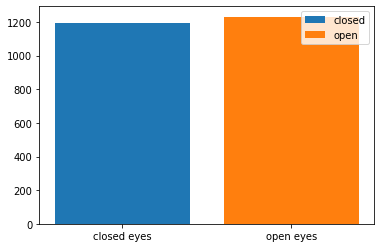

In [14]:
fig, ax = plt.subplots()

ax.bar(0, len(faces_closed), label='closed')
ax.bar(1, len(faces_opened), label='open')
ax.legend()
ax.set_xticks(np.arange(0,2))
ax.set_xticklabels(['closed eyes', 'open eyes'])
plt.show()

## Criando o vetor de caracteristicas e o vetor de label

**Obs.:** Codificação das labels:

| Estado dos olhos | y |
|:--------------:|:-------------:|
|       Fechado        |       0       |
|       Aberto        |       1       |

In [15]:
X = []
y = []
for img in faces_closed:
    features = extract_features(img)
    X.append(features)
    y.append(0)

for img in faces_opened:
    features = extract_features(img)
    X.append(features)
    y.append(1)

In [16]:
# convertendo para numpy array
X = np.array(X).reshape(-1,2)
y = np.array(y).reshape(-1)

In [17]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2423, 2)
y shape: (2423,)


## Separando os dados para validação cruzada

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1938, 2)
y_train shape: (1938,)
X_test shape: (485, 2)
y_test shape: (485,)


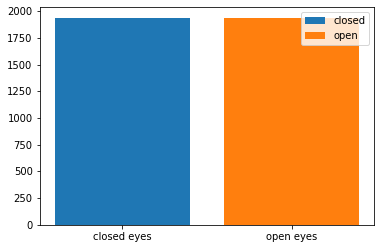

In [21]:
fig, ax = plt.subplots()

ax.bar(0, len(y_train==0), label='closed')
ax.bar(1, len(y_train==1), label='open')
ax.legend()
ax.set_xticks(np.arange(0,2))
ax.set_xticklabels(['closed eyes', 'open eyes'])
plt.show()

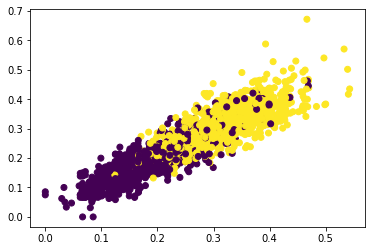

In [22]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train[:])
plt.show()

## Criando o modelo, o classificador

In [23]:
from sklearn import svm

In [43]:
# SVM
svm_model = svm.SVC(C=0.1)

## Treinamento

In [44]:
svm_model.fit(X_train, y_train)

SVC(C=0.1)

## Validação

In [45]:
y_pred = svm_model.predict(X_test)

In [46]:
cm = confusion_matrix(y_test, y_pred)

In [47]:
cm

array([[52884, 60606],
       [56726, 65009]])

In [48]:
compute_metrics_from_cm(cm)

{'accuracy': 0.5011924752896163,
 'precision': 0.4824742268041237,
 'recall': 0.465979381443299,
 'f1_score': 0.47408337068579115}

# TESTES

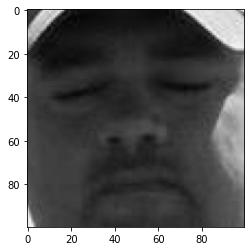

In [32]:
%matplotlib inline

img = cv2.imread("../dataset/ClosedFace/closed_eye_0001.jpg_face_1.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')

plt.show()

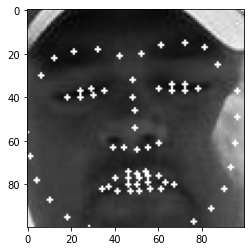

In [33]:
landmarks = get_landmarks(img)
img_t = draw_landmarks(img, landmarks)

plt.imshow(img_t, 'gray')
plt.show()

In [34]:
extract_features(img)

(0.17848558013543783, 0.16666666666666666)

In [35]:
img.shape

(100, 100)

# Referências
[dlib] http://dlib.net/face_landmark_detection.py.html